In [1]:
import warnings
import os
os.environ['OMP_NUM_THREADS'] = '1'
warnings.simplefilter("ignore")
os.environ["PYTHONWARNINGS"] = "ignore"
import logging
logging.basicConfig(force=True)

import pandas as pd
from castle.metrics import MetricsDAG
from drbo.pruners import prune_linear, prune_cit
from drbo import DrBO
from drbo.utils import sim_data, read_nonlinear_gp, read_sachs, viz_history

Note: this demo is run on Intel® Core™ i9-12900 and NVIDIA GeForce RTX 4060 Ti.

## Linear-Gaussian data

In [2]:
# Linear-Gaussian data with dense graphs 30ER4
data = sim_data(samples=1000, nodes=30, edges_per_node=4, random_state=1)
pred = DrBO(
    X=data.X,
    GT=data.B, # for tracking performance only
    score_method='BIC',
    score_params={
        'noise_var': 'ev',
        'reg': 'linear'
    },
    max_evals=4000, # the more the better
    pruner=prune_linear,
    device='cuda',
    verbose=True,
)
# in the progress bar: rmse & r2 = error metrics between estimated & true scores, GT = BIC score of ground truth, Best = Best BIC so far, both divided by nxd
print(MetricsDAG._count_accuracy(prune_linear(data.X, pred['raw']), data.B))

  0%|          | 0/4000 [00:00<?, ?it/s]WARNING:jax._src.xla_bridge:An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.
4032it [02:13, 30.19it/s, rmse=0.058,r2=-0.055,GT=-0.028299,Best=-0.070548@4027,shd=0]                            

{'fdr': 0.0, 'tpr': 1.0, 'fpr': 0.0, 'shd': 0, 'nnz': 124, 'precision': np.float64(1.0), 'recall': np.float64(1.0), 'F1': np.float64(1.0), 'gscore': np.float64(1.0)}


Learning curve:

,step,timestamp,test_rmse,test_r2,BIC,fdr,tpr,fpr,shd,nnz,precision,recall,F1,gscore
0,0,0.734272,4.515595,-28.547313,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,64,0.747083,NaN,NaN,-2.512528,0.5545,0.3629,0.1801,127.0,101.0,0.4455,0.3629,0.400,0.0
2,64,3.032615,0.909988,-18.071860,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,128,3.044910,NaN,NaN,-2.043715,0.5586,0.3952,0.1994,131.0,111.0,0.4414,0.3952,0.417,0.0
4,128,5.167479,0.460087,-10.130449,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


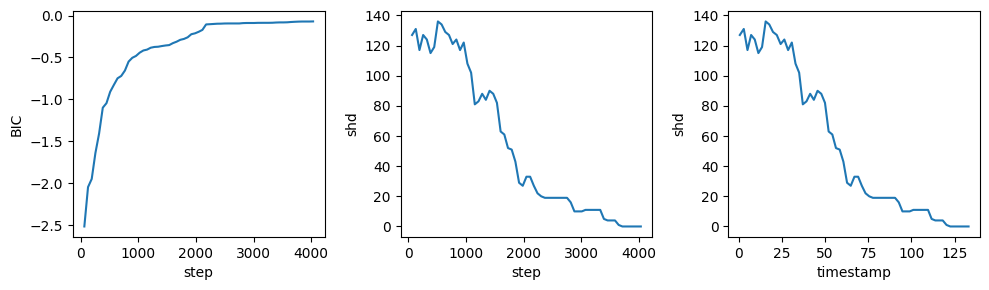

In [3]:
df = pd.DataFrame(pred['history'])
display(df.head())
viz_history(df)

## Nonlinear data with Gaussian Process

In [4]:
# First, download the data: https://github.com/kurowasan/GraN-DAG/blob/master/data/data_p10_e40_n1000_GP.zip
# Then, extract it to 'data/'
data = read_nonlinear_gp('data_p10_e40_n1000_GP', id=1)
pred = DrBO(
    X=data['X'],
    GT=data['GT'], # for tracking performance only
    score_method='BIC',
    score_params={
        'noise_var': 'nv', # Non-equal noise variant
        'reg': 'gp',
        'alpha': 1 # regularization for GP
    },
    max_evals=10000, # the more the better
    device='cuda',
    verbose=True,
)
print(MetricsDAG._count_accuracy(pred['raw'], data['GT']))

10048it [08:34, 19.52it/s, rmse=0.062,r2=-30753.129,GT=2.025187,Best=2.025187@1669,shd=0]                           

{'fdr': 0.0, 'tpr': 1.0, 'fpr': 0.0, 'shd': 0, 'nnz': 39, 'precision': np.float64(1.0), 'recall': np.float64(1.0), 'F1': np.float64(1.0), 'gscore': np.float64(1.0)}


Learning curve:

,step,timestamp,test_rmse,test_r2,BIC,fdr,tpr,fpr,shd,nnz,precision,recall,F1,gscore
0,0,127.648281,0.767720,-14.755777,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,64,127.651038,NaN,NaN,1.527734,0.3529,0.5641,2.0000,21.0,34.0,0.6471,0.5641,0.6027,0.2564
2,64,188.707692,0.216466,-0.753145,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,128,188.710503,NaN,NaN,1.710057,0.2821,0.7179,1.8333,16.0,39.0,0.7179,0.7179,0.7179,0.4359
4,128,211.638206,0.165055,-9.498607,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


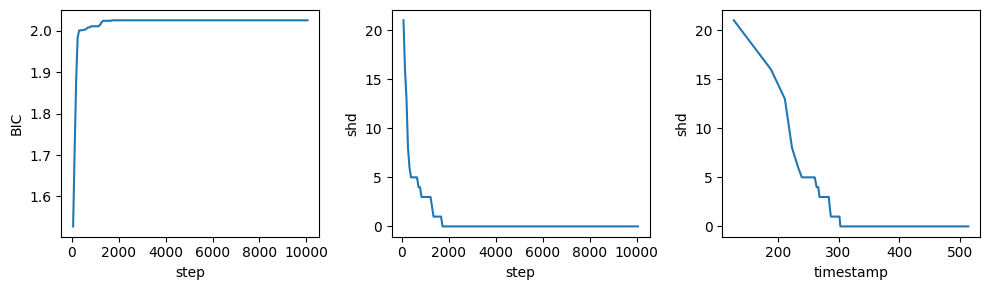

In [5]:
df = pd.DataFrame(pred['history'])
display(df.head())
viz_history(df)

## Sachs data

In [2]:
# This requires 2 files "data/sachs/observations.csv" and "data/sachs/dag.csv"
data = read_sachs()
pred = DrBO(
    X=data['X'],
    GT=data['GT'],
    score_method='BIC',
    normalize=True,
    score_params={
        'noise_var': 'nv',
        'reg': 'gp',
        'med_bw': True,
    },
    pruner=prune_cit,
    max_evals=5000,
    device='cuda',
    verbose=True,
)
print(MetricsDAG._count_accuracy(prune_cit(data['X'], pred['raw']), data['GT']))

  0%|          | 0/5000 [00:00<?, ?it/s]WARNING:jax._src.xla_bridge:An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.
5056it [10:33,  7.99it/s, rmse=0.892,r2=-77.180,GT=1.164726,Best=3.432928@3144,shd=9]                               


{'fdr': 0.1111, 'tpr': 0.4706, 'fpr': 0.0263, 'shd': 9, 'nnz': 9, 'precision': np.float64(0.8889), 'recall': np.float64(0.4706), 'F1': np.float64(0.6154), 'gscore': np.float64(0.4118)}


,step,timestamp,test_rmse,test_r2,BIC,fdr,tpr,fpr,shd,nnz,precision,recall,F1,gscore
0,0,44.895277,1.092228,-8.534932,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,64,59.966179,NaN,NaN,2.078590,0.5,0.2353,0.1053,14.0,8.0,0.5,0.2353,0.3200,0.0
2,64,86.406083,0.449458,-2.171872,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,128,105.139927,NaN,NaN,2.807389,0.6,0.2353,0.1579,14.0,10.0,0.4,0.2353,0.2963,0.0
4,128,123.867576,0.260146,-1.127990,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


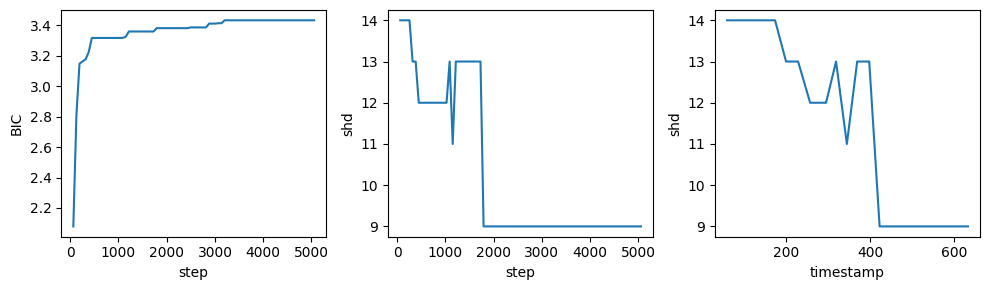

In [3]:
df = pd.DataFrame(pred['history'])
display(df.head())
viz_history(df)